
Image processing...

Rank: 300 SVD shape: (1024, 256) (256,) (256, 256)


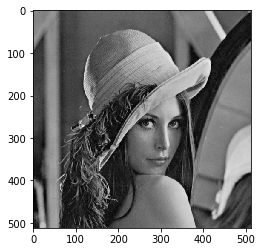

In [2]:
import numpy as np
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')


def shuffle_arr(A, block_size=(16, 16)):
    M, N = A.shape
    m, n = block_size
    X = []
    for i in range(M // m):
        a = i * m
        for j in range(N // n):
            b = j * n
            cell = A[a:a + m, b:b + n]
            cell = cell.reshape((1, -1))
            X.append(cell[0])
    X = np.array(X)
    return X


def unshuffle_arr(X, old_size, block_size=(16, 16)):
    m, n = block_size
    M, N = old_size
    M, N = M - (M % m), N - (N % n)
    height, width = M // m, N // n
    A = [None] * height
    for i in range(len(X)):
        TMP = X[i].reshape(block_size)
        if (i * n) % N == 0:
            A[(i * n) // N] = TMP.copy()
        else:
            A[(i * n) // N] = np.hstack([A[(i * n) // N], TMP])
    res = A[0]
    for i in range(1, len(A)):
        res = np.vstack([res, A[i]])
    return res


def dot_D_A(d, c):
    return np.array([c[i] * d[i] for i in range(len(d))])


def SVD(A):
    AAT = np.dot(A, A.T)
    ATA = np.dot(A.T, A)

    eigvals_ATA, eigvecs_ATA = np.linalg.eig(ATA)

    eigvecs_ATA = eigvecs_ATA.T
    eigvecs_ATA = np.array([
        x
        for _, x in sorted(
            zip(eigvals_ATA, eigvecs_ATA),
            key=lambda pair: pair[0],
            reverse=True)
    ])
    eigvecs_ATA = eigvecs_ATA.T

    eigvals_ATA = np.array([x for x in eigvals_ATA if x > 1e-8])
    sing_ATA = np.sqrt(eigvals_ATA)

    S = np.array(sorted(sing_ATA, reverse=True))  # HURRAY

    VT = eigvecs_ATA.T  # HURRAY

    UT = np.zeros((len(S), len(A)))
    for i in range(len(S)):
        d = np.dot((1 / S[i]), A)
        UT[i] = np.dot(d, VT[i])
    U = UT.T  # HURRAY
    return U, S, VT


def apply_rank(U, S, VT, r):
    if r is None:
        r = len(S)
    S_r = S[:r]
    U_r = U[:, :r]
    VT_r = VT[:r]
    print("Rank:", r, "SVD shape:", U_r.shape, S_r.shape, VT_r.shape)
    return U_r, S_r, VT_r


def SVD_to_A(U, S, VT):
    A_RECOVERED = np.dot(U, dot_D_A(S, VT))
    return A_RECOVERED


def weightedAverage(pixel):
    return 0.299 * pixel[0] + 0.587 * pixel[1] + 0.114 * pixel[2]


def rgb2grey(arr, size):
    h, w = size
    arr = arr.reshape(h, w, 3)
    grey = np.zeros((h, w))

    for rownum in range(len(arr)):
        for colnum in range(len(arr[rownum])):
            grey[rownum][colnum] = weightedAverage(arr[rownum][colnum])
    grey = grey.reshape(w, h)
    return grey


def load_img(path='lena.jpg', im_type='gray'):
    if im_type.lower() == 'gray' or im_type.lower() == 'grey':
        im = Image.open(path)

    if im_type.lower() == 'rgb':
        im = Image.open(path)

    return im


def img_to_arr_colored(im):
    height, width = im.size
    arr = np.array(im.getdata())
    arr = arr.reshape(3, height, width)
    r = arr[0]
    g = arr[1]
    b = arr[2]
    return r, g, b


def img_to_arr_grey(im):
    try:
        w, h = im.size
        arr = np.array(im.getdata())
        arr = rgb2grey(arr, (h, w))
        print("Converted from RGB to grayscale")
    except:
        height, width = im.size
        arr = np.array(im.getdata())
        arr = arr.reshape(height, width)
    return arr


def arr_to_img(arr):
    return Image.fromarray(arr)


def show_img(im):
    plt.imshow(im)
    plt.show()


def SSVD(file_name, rank=None, im_type='gray', shuffled=True):
    block_size = (16, 16)
    print("\nImage processing...\n")
    if im_type.lower() == 'rgb':
        return SSVD_colored(
            file_name, rank, block_size=block_size, shuffled=shuffled)
    if im_type.lower() == 'gray' or im_type.lower() == 'grey':
        return SSVD_gray(
            file_name, rank, block_size=block_size, shuffled=shuffled)


def SSVD_colored(file_name, rank=None, block_size=None, shuffled=True):
    im = load_img(file_name, im_type='rgb')
    h, w = im.size
    if shuffled:
        h, w = im.size
        sqrt = int((h * w)**0.5)
        im = im.resize((sqrt, sqrt))
    r, g, b = img_to_arr_colored(im)
    res = []
    for i, arr in enumerate((r, g, b)):
        if i == 0:
            print("Red color processing..")
        elif i == 1:
            print("Green color processing..")
        else:
            print("Blue color processing..")
        if shuffled:
            arr = shuffle_arr(arr, block_size=block_size)
        U, S, VT = SVD(arr)
        U_r, S_r, VT_r = apply_rank(U, S, VT, rank)
        arr = SVD_to_A(U_r, S_r, VT_r)
        if shuffled:
            arr = unshuffle_arr(arr, (sqrt, sqrt), block_size=block_size)
        arr[(arr > 255)] = 255
        arr[(arr < 0)] = 0
        res.append(arr)
    new_h, new_w = res[0].shape
    new_im = np.array(res)
    new_im = new_im.reshape(new_w, new_h, 3)
    im = arr_to_img(np.uint8(new_im))
    if shuffled:
        im = im.resize((h, w))
    return im


def SSVD_gray(file_name, rank=None, block_size=None, shuffled=True):
    im = load_img(file_name)
    h, w = im.size
    if shuffled:
        h, w = im.size
        sqrt = int((h * w)**0.5)
        im = im.resize((sqrt, sqrt))
    arr = img_to_arr_grey(im)
    if shuffled:
        arr = shuffle_arr(arr, block_size=block_size)
    U, S, VT = SVD(arr)
    U_r, S_r, VT_r = apply_rank(U, S, VT, rank)
    arr = SVD_to_A(U_r, S_r, VT_r)
    if shuffled:
        arr = unshuffle_arr(arr, (sqrt, sqrt), block_size=block_size)
        im = arr_to_img(arr)
        im = im.resize((h, w))
        return im
    h, w = arr.shape
    arr = arr.reshape(w, h)
    return arr_to_img(arr)


# new_im = SSVD('../img/lena.jpg', im_type='gray', rank=10)
new_im = SSVD('../img/lena.jpg', im_type='gray', rank=300, shuffled=True)
show_img(new_im)